
# Section 1:  Data Acquisition and Preparation

In [1]:
# Importing the library
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Defining the list of top 20 NSE stocks 
nse_top20 = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS',
    'ICICIBANK.NS', 'KOTAKBANK.NS', 'HDFC.NS', 'BHARTIARTL.NS', 'ITC.NS',
    'SBIN.NS', 'ASIANPAINT.NS', 'BAJFINANCE.NS', 'MARUTI.NS', 'LT.NS',
    'AXISBANK.NS', 'HCLTECH.NS', 'ULTRACEMCO.NS', 'M&M.NS', 'SUNPHARMA.NS'
]
# Defing the start date and end date for feaching the historical data
start_date = '2019-07-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetching the data
stock_data = {}
for ticker in nse_top20:
    print(f"Fetching data for {ticker}")
    stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)

print("Data acquisition completed.")

# Checking the quality of data 
for ticker, data in stock_data.items():
    if data.isnull().values.any():
        print(f"Missing values found in {ticker}, handling missing values.")
        stock_data[ticker] = data.fillna(method='ffill').dropna()


Fetching data for RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Fetching data for TCS.NS



[*********************100%%**********************]  1 of 1 completed


Fetching data for HDFCBANK.NS
Fetching data for HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for INFY.NS
Fetching data for ICICIBANK.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for KOTAKBANK.NS
Fetching data for HDFC.NS


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['HDFC.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Fetching data for BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ITC.NS
Fetching data for SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ASIANPAINT.NS
Fetching data for BAJFINANCE.NS


[*********************100%%**********************]  1 of 1 completed


Fetching data for MARUTI.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Fetching data for LT.NS



[*********************100%%**********************]  1 of 1 completed

Fetching data for AXISBANK.NS



[*********************100%%**********************]  1 of 1 completed


Fetching data for HCLTECH.NS
Fetching data for ULTRACEMCO.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for M&M.NS
Fetching data for SUNPHARMA.NS


[*********************100%%**********************]  1 of 1 completed

Data acquisition completed.


# Section 2: Strategy Implementation

In [2]:
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

def implement_strategy(data, short_window=50, long_window=200):
    if len(data) < long_window:
        print(f"Not enough data to apply strategy for {data.name}")
        return data

    print(f"Implementing strategy for {data.name}...")
    data['SMA50'] = calculate_sma(data, short_window)
    data['SMA200'] = calculate_sma(data, long_window)
    data['Signal'] = 0
    data.loc[data.index[short_window:], 'Signal'] = np.where(data['SMA50'].iloc[short_window:] > data['SMA200'].iloc[short_window:], 1, 0)
    data['Position'] = data['Signal'].diff()
    print(f"Strategy implementation completed for {data.name}.")
    return data

for ticker, data in stock_data.items():
    data.name = ticker  # Set name for better logging
    print(f"Applying strategy on {ticker}")
    stock_data[ticker] = implement_strategy(data)


Applying strategy on RELIANCE.NS
Implementing strategy for RELIANCE.NS...
Strategy implementation completed for RELIANCE.NS.
Applying strategy on TCS.NS
Implementing strategy for TCS.NS...
Strategy implementation completed for TCS.NS.
Applying strategy on HDFCBANK.NS
Implementing strategy for HDFCBANK.NS...
Strategy implementation completed for HDFCBANK.NS.
Applying strategy on HINDUNILVR.NS
Implementing strategy for HINDUNILVR.NS...
Strategy implementation completed for HINDUNILVR.NS.
Applying strategy on INFY.NS
Implementing strategy for INFY.NS...
Strategy implementation completed for INFY.NS.
Applying strategy on ICICIBANK.NS
Implementing strategy for ICICIBANK.NS...
Strategy implementation completed for ICICIBANK.NS.
Applying strategy on KOTAKBANK.NS
Implementing strategy for KOTAKBANK.NS...
Strategy implementation completed for KOTAKBANK.NS.
Applying strategy on HDFC.NS
Not enough data to apply strategy for HDFC.NS
Applying strategy on BHARTIARTL.NS
Implementing strategy for BHAR

# Section 3: Backtesting

In [3]:
def backtest_strategy(data):
    if len(data) == 0:
        print(f"No data to backtest for {data.name}")
        return {}, [], []

    print(f"Backtesting strategy for {data.name}...")
    initial_capital = 1000000  # Initial capital
    shares = 0
    positions = []
    capital_over_time = []

    for index, row in data.iterrows():
        if row['Position'] == 1:  # Buy signal
            shares = initial_capital // row['Close']
            initial_capital -= shares * row['Close']
            positions.append((index, 'Buy', shares, row['Close']))
        elif row['Position'] == -1:  # Sell signal
            initial_capital += shares * row['Close']
            positions.append((index, 'Sell', shares, row['Close']))
            shares = 0
        total_value = initial_capital + shares * row['Close']
        capital_over_time.append(total_value)

    total_value = initial_capital + shares * data.iloc[-1]['Close']
    total_return = (total_value / 1000000) - 1

    annualized_return = ((1 + total_return) ** (1/5)) - 1
    max_drawdown = ((data['Close'].cummax() - data['Close']).max()) / data['Close'].cummax().max()
    sharpe_ratio = (data['Close'].pct_change().mean() / data['Close'].pct_change().std()) * np.sqrt(252)
    win_loss_ratio = len(data[data['Position'] == 1]) / len(data[data['Position'] == -1])
    num_trades = len(data[data['Position'] != 0])

    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Maximum Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Win/Loss Ratio': win_loss_ratio,
        'Number of Trades': num_trades
    }

    print(f"Backtesting completed for {data.name}.")
    return metrics, positions, capital_over_time

metrics_summary = {}
positions_summary = {}
capital_summary = {}

for ticker, data in stock_data.items():
    data.name = ticker  # Set name for better logging
    print(f"Backtesting on {ticker}")
    metrics, positions, capital_over_time = backtest_strategy(data)
    metrics_summary[ticker] = metrics
    positions_summary[ticker] = positions
    capital_summary[ticker] = capital_over_time

print("All backtesting completed.")


Backtesting on RELIANCE.NS
Backtesting strategy for RELIANCE.NS...
Backtesting completed for RELIANCE.NS.
Backtesting on TCS.NS
Backtesting strategy for TCS.NS...
Backtesting completed for TCS.NS.
Backtesting on HDFCBANK.NS
Backtesting strategy for HDFCBANK.NS...
Backtesting completed for HDFCBANK.NS.
Backtesting on HINDUNILVR.NS
Backtesting strategy for HINDUNILVR.NS...
Backtesting completed for HINDUNILVR.NS.
Backtesting on INFY.NS
Backtesting strategy for INFY.NS...
Backtesting completed for INFY.NS.
Backtesting on ICICIBANK.NS
Backtesting strategy for ICICIBANK.NS...
Backtesting completed for ICICIBANK.NS.
Backtesting on KOTAKBANK.NS
Backtesting strategy for KOTAKBANK.NS...
Backtesting completed for KOTAKBANK.NS.
Backtesting on HDFC.NS
No data to backtest for HDFC.NS
Backtesting on BHARTIARTL.NS
Backtesting strategy for BHARTIARTL.NS...
Backtesting completed for BHARTIARTL.NS.
Backtesting on ITC.NS
Backtesting strategy for ITC.NS...
Backtesting completed for ITC.NS.
Backtesting on 

# Section 4: Visualization

Plotting performance for RELIANCE.NS


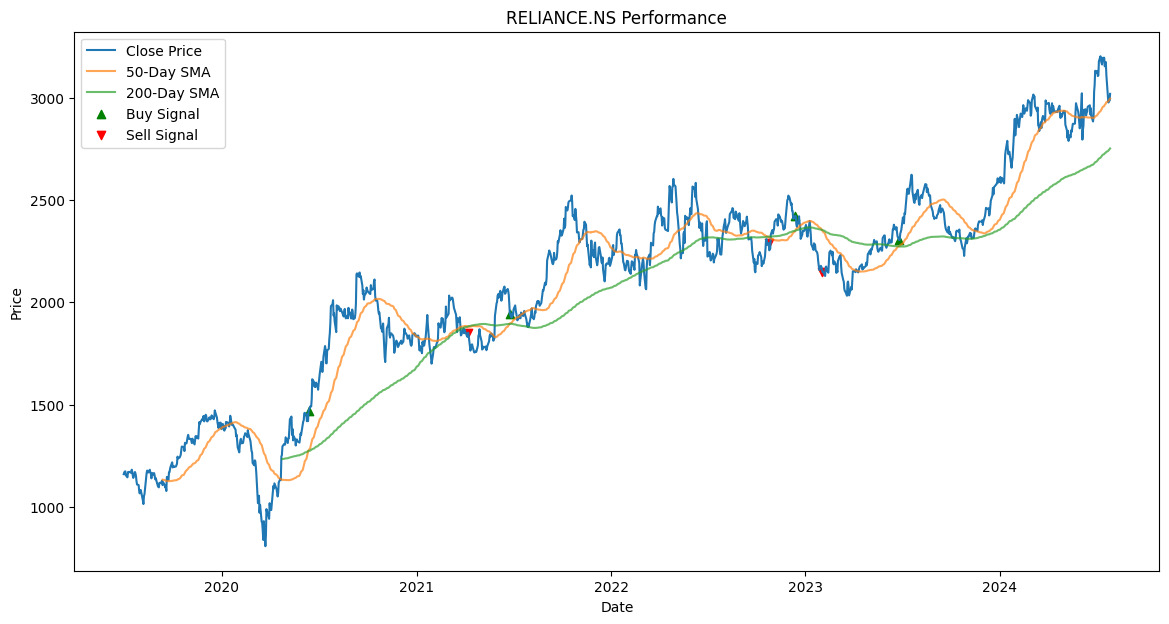

Plotting capital over time for RELIANCE.NS


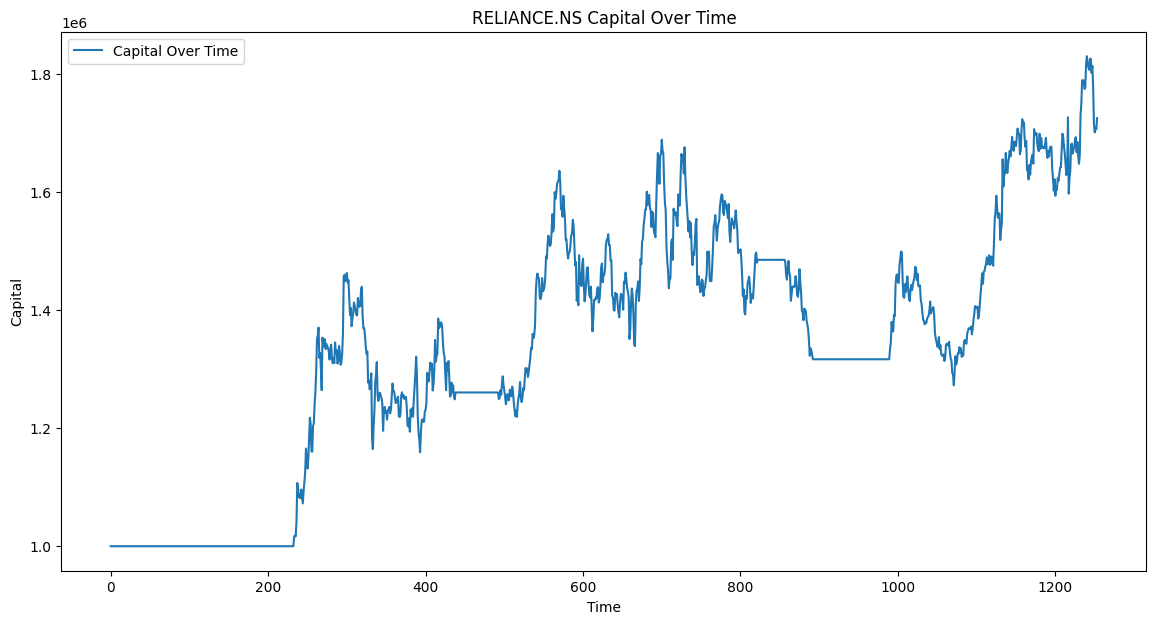

Plotting performance for TCS.NS


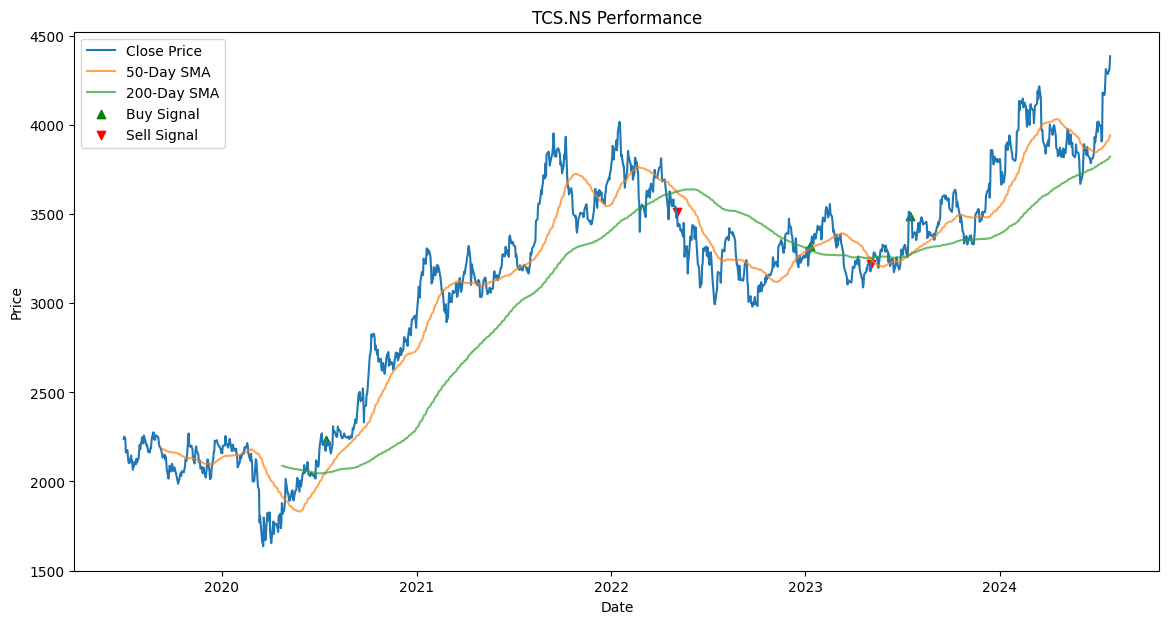

Plotting capital over time for TCS.NS


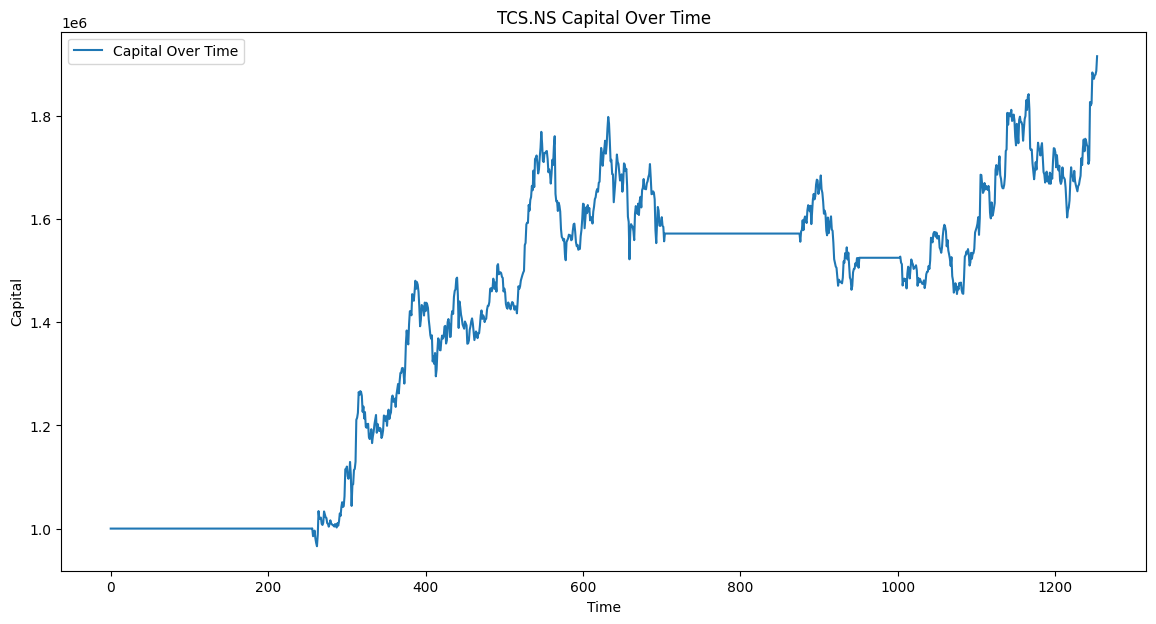

Plotting performance for HDFCBANK.NS


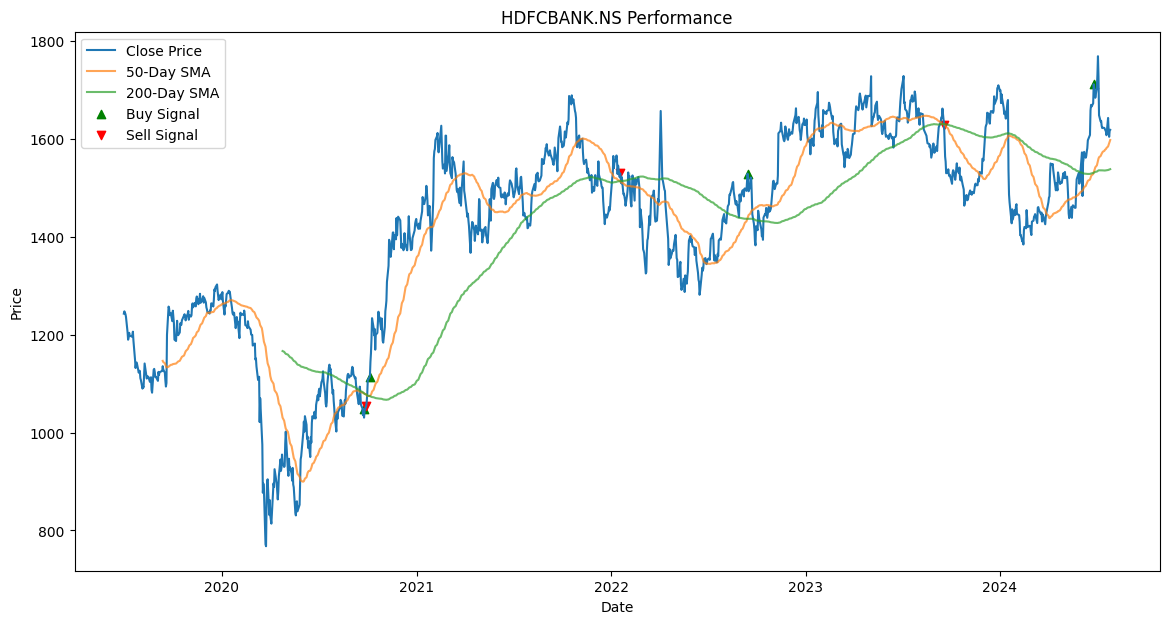

Plotting capital over time for HDFCBANK.NS


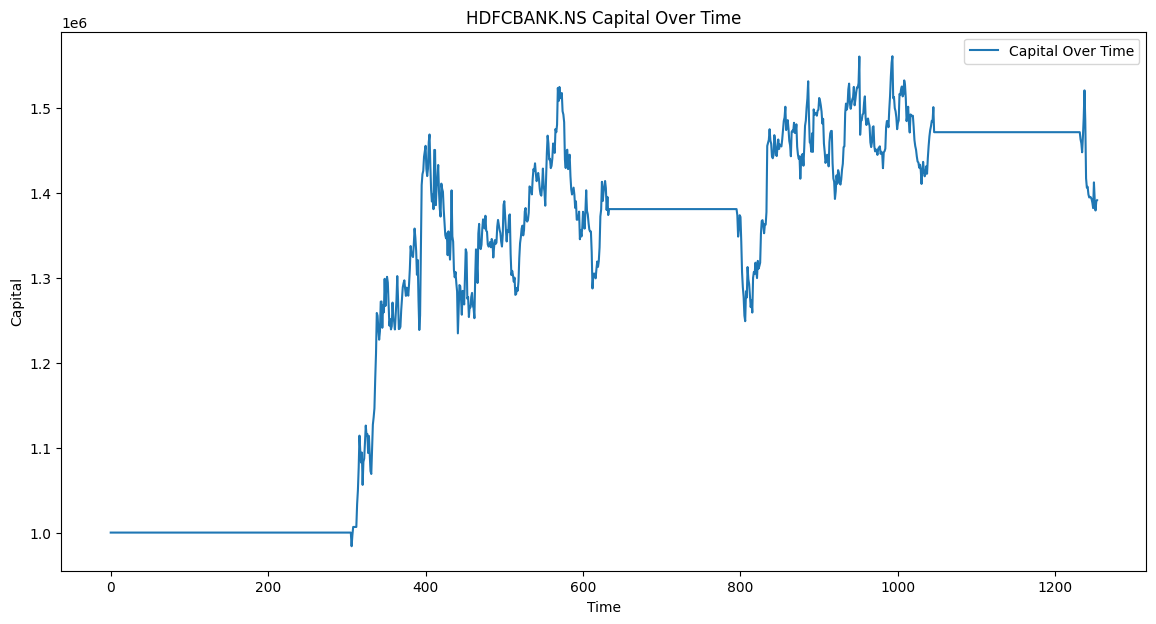

Plotting performance for HINDUNILVR.NS


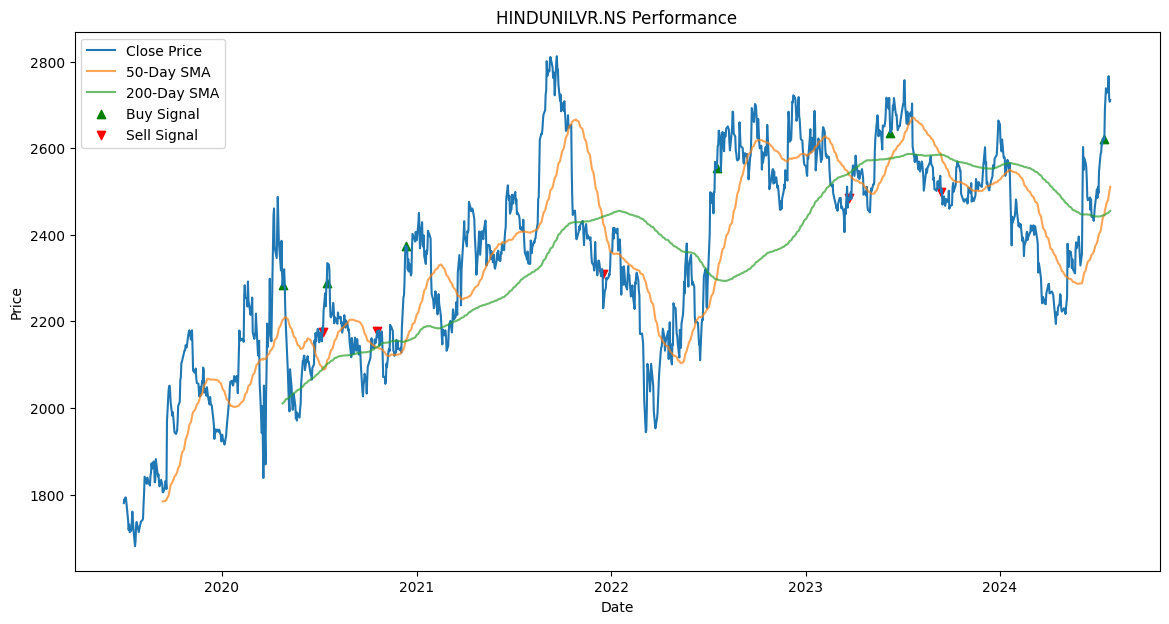

Plotting capital over time for HINDUNILVR.NS


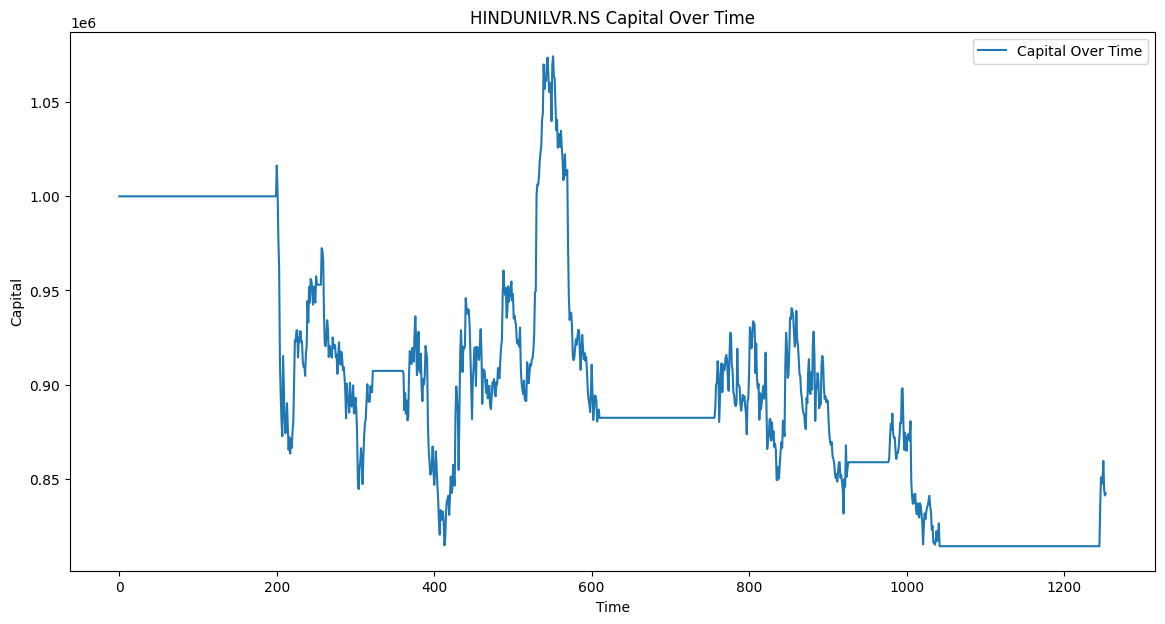

Plotting performance for INFY.NS


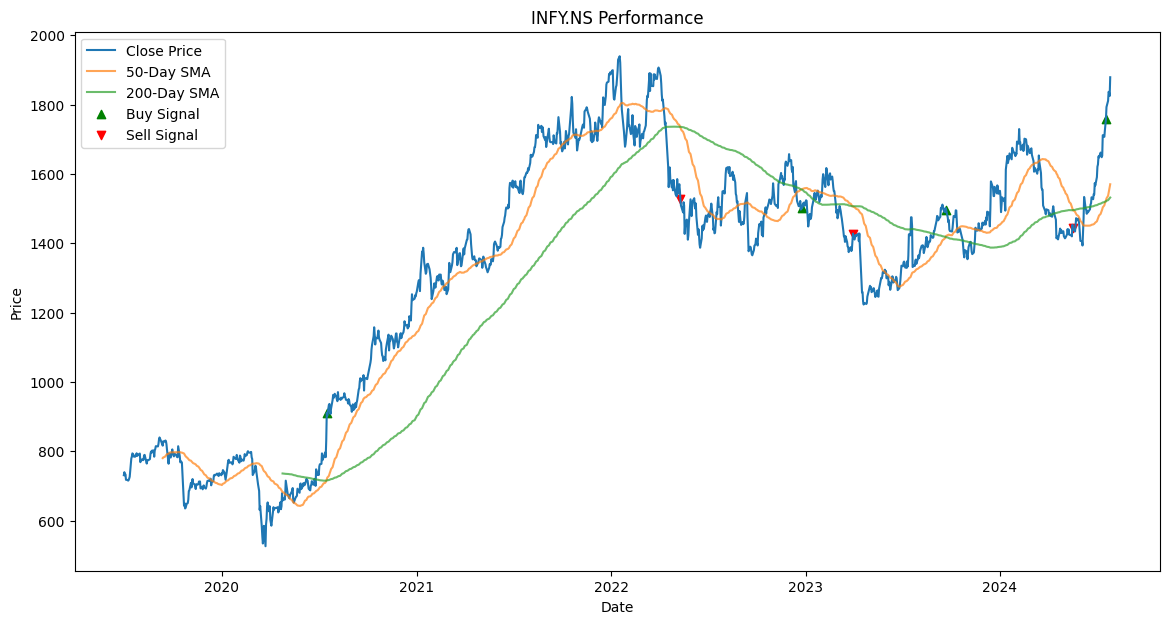

Plotting capital over time for INFY.NS


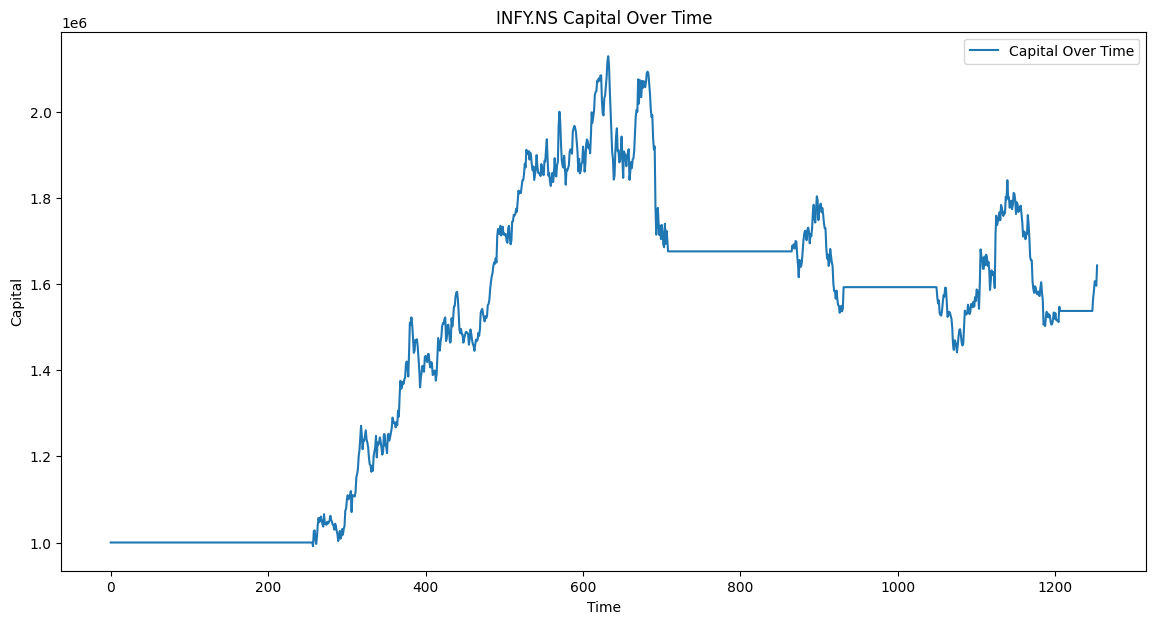

Plotting performance for ICICIBANK.NS


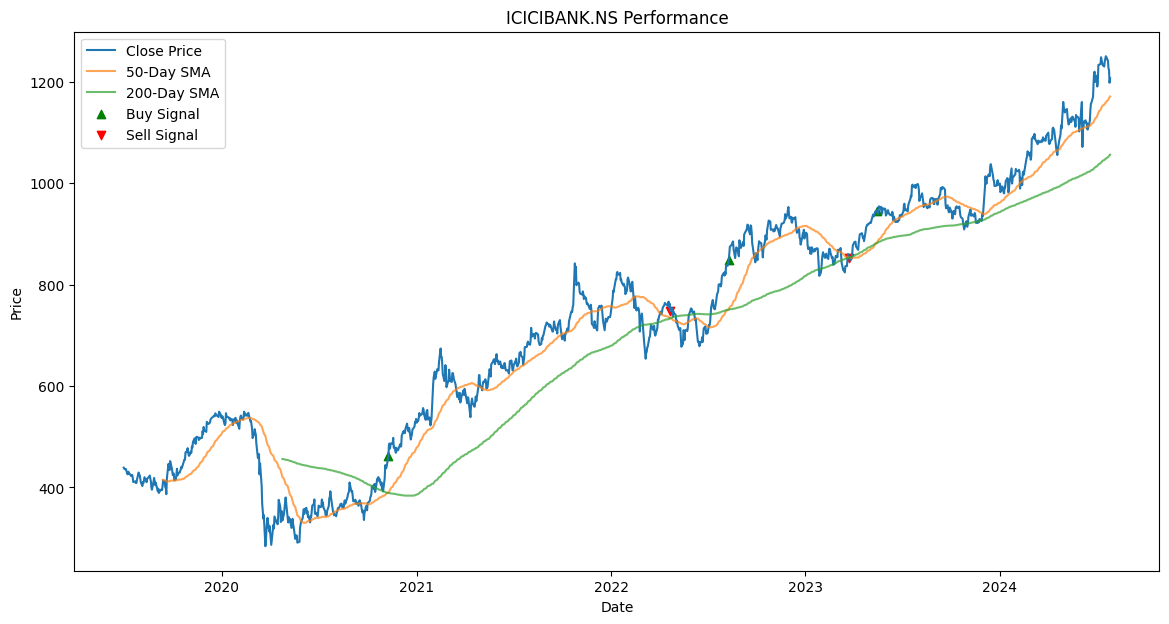

Plotting capital over time for ICICIBANK.NS


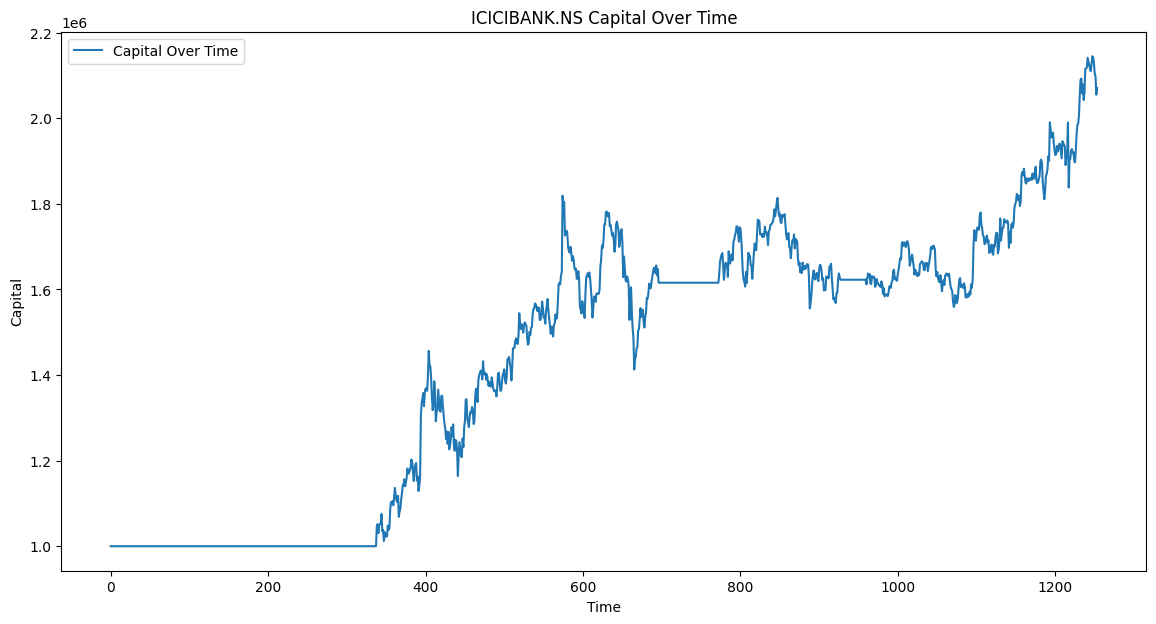

Plotting performance for KOTAKBANK.NS


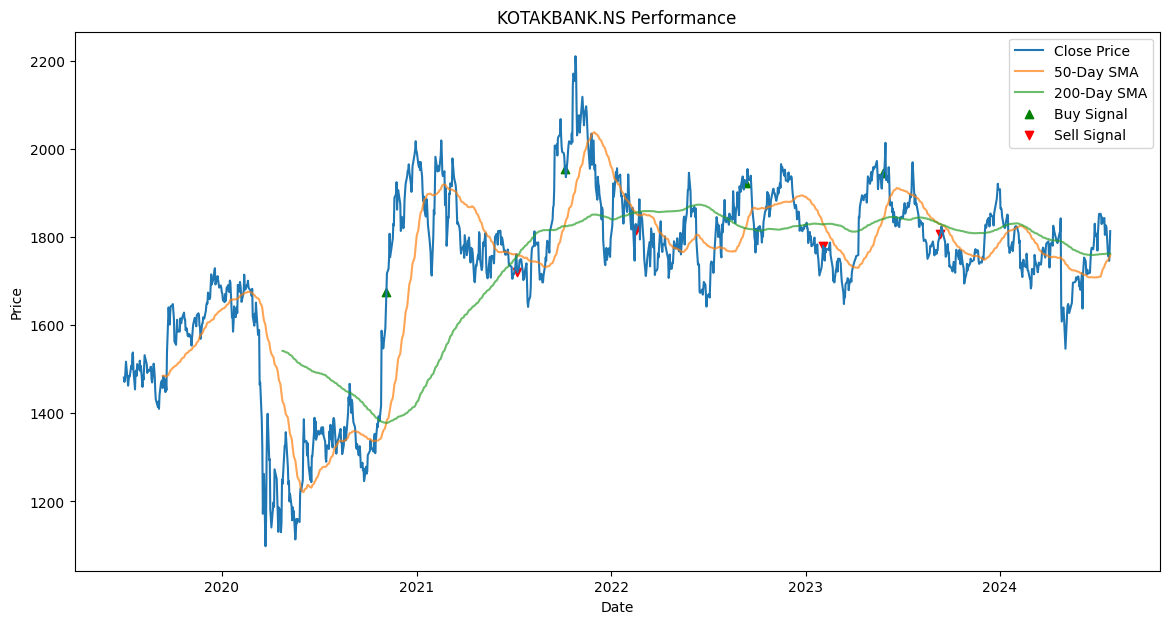

Plotting capital over time for KOTAKBANK.NS


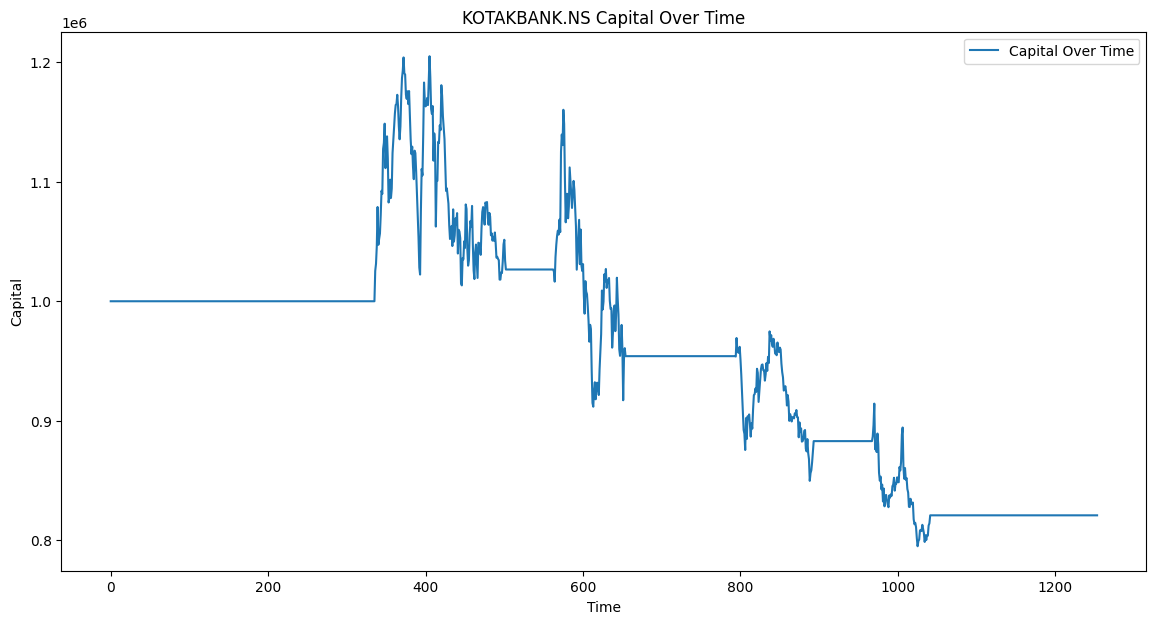

Plotting performance for HDFC.NS
Not enough data to plot for HDFC.NS
Plotting capital over time for HDFC.NS


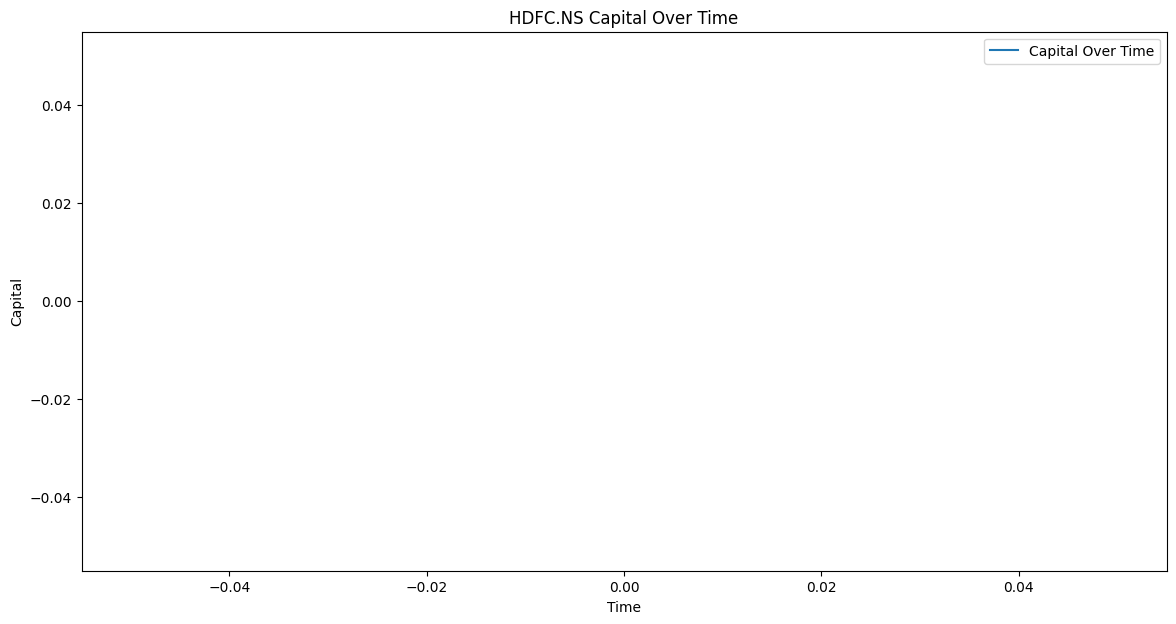

Plotting performance for BHARTIARTL.NS


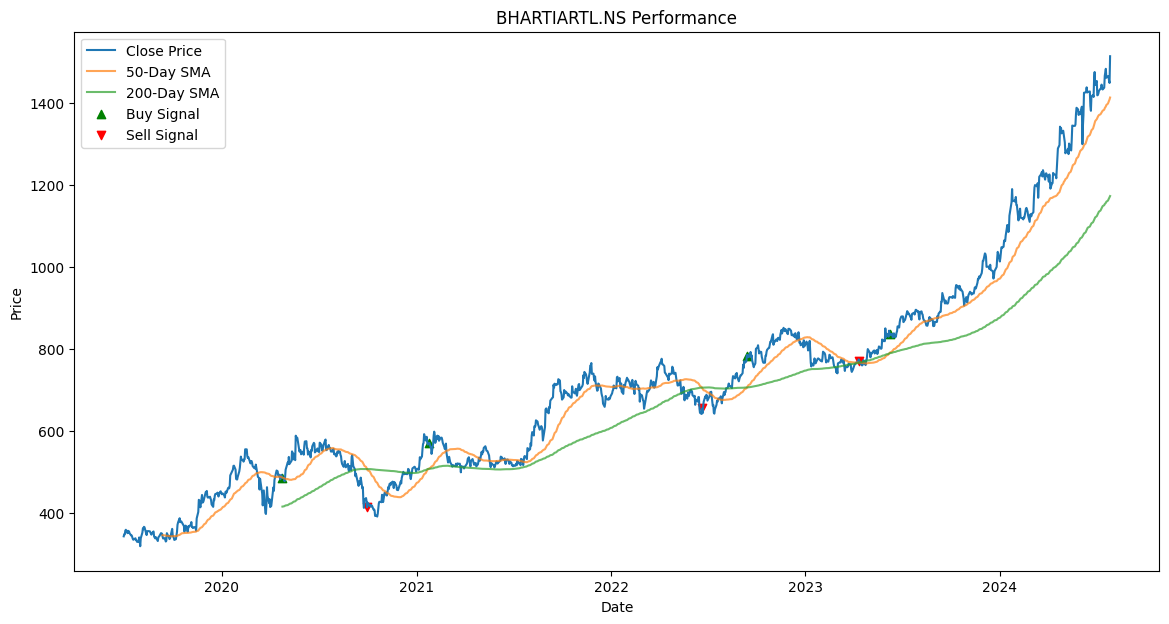

Plotting capital over time for BHARTIARTL.NS


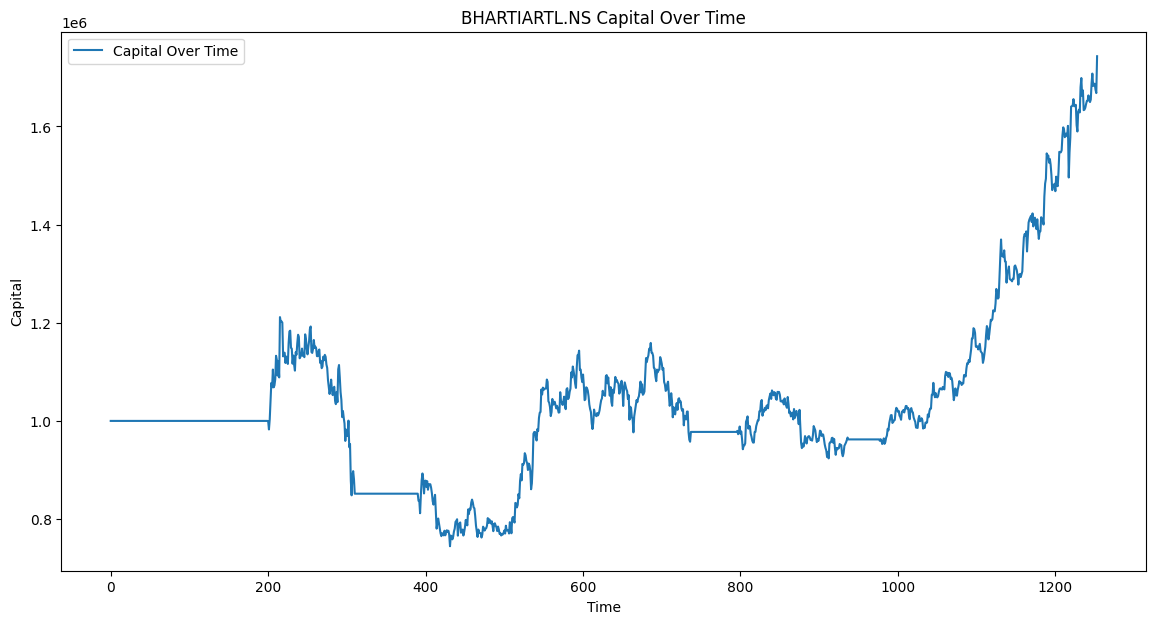

Plotting performance for ITC.NS


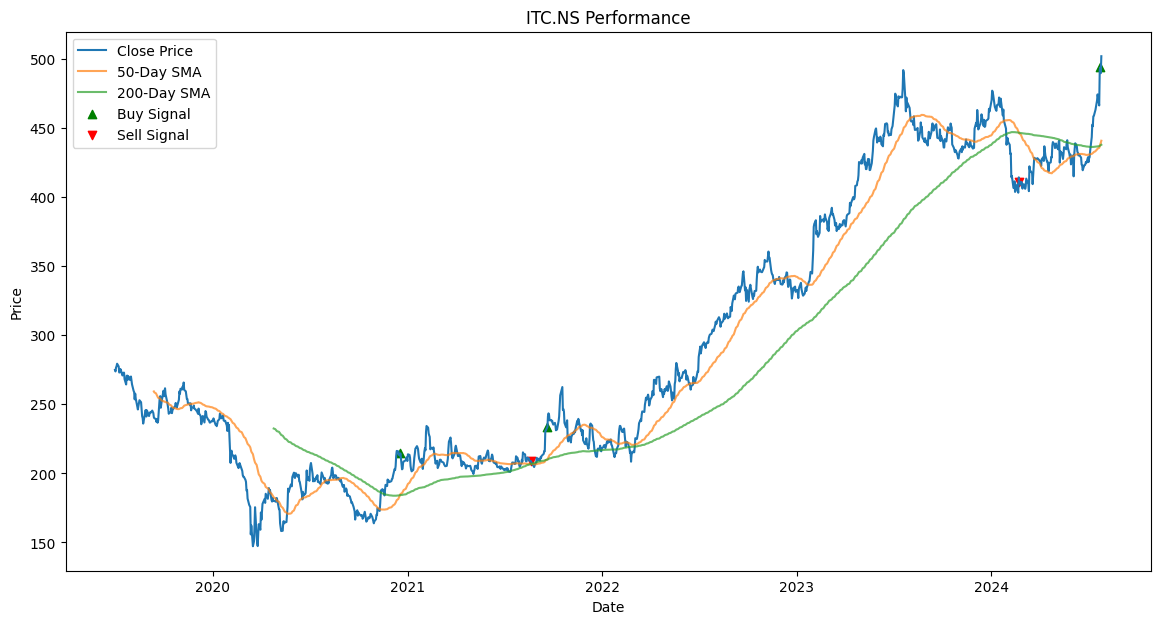

Plotting capital over time for ITC.NS


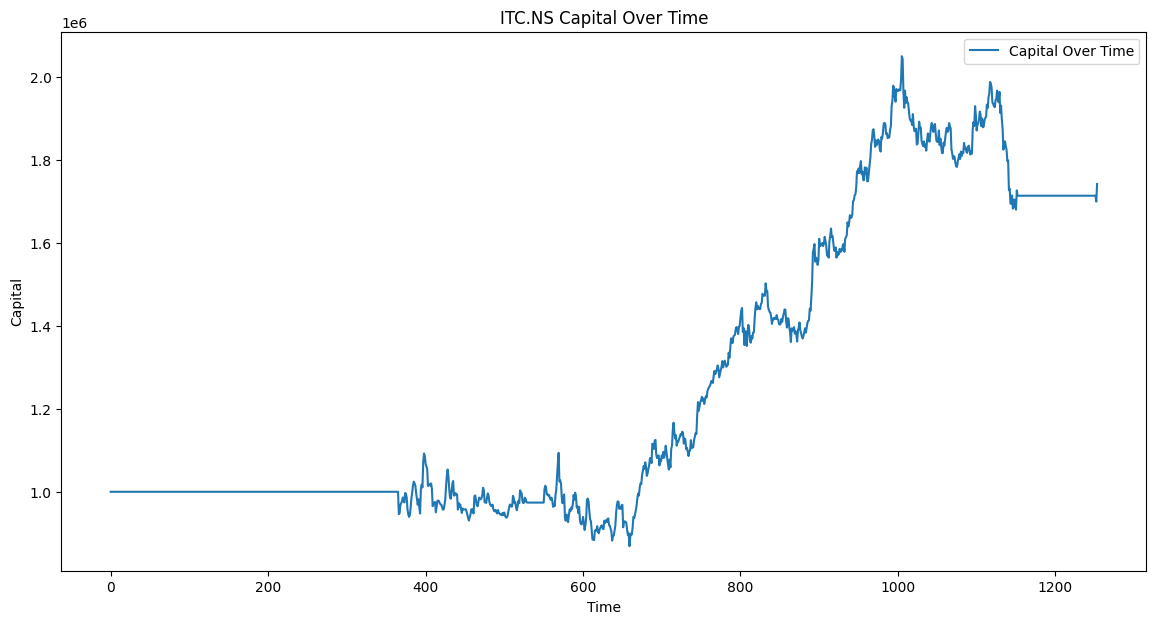

Plotting performance for SBIN.NS


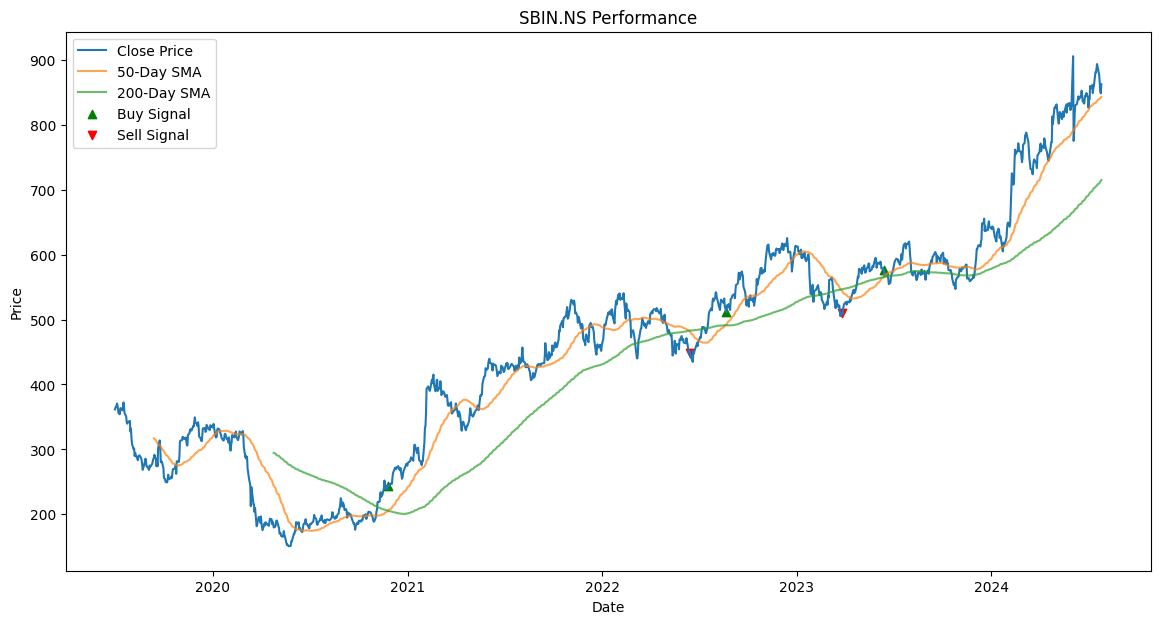

Plotting capital over time for SBIN.NS


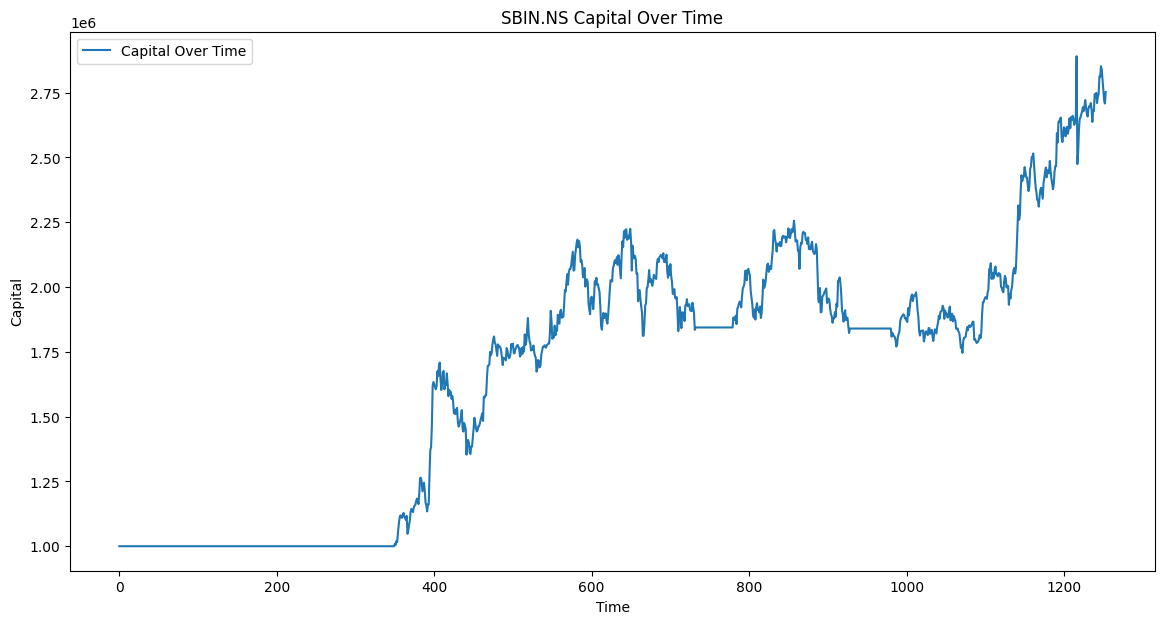

Plotting performance for ASIANPAINT.NS


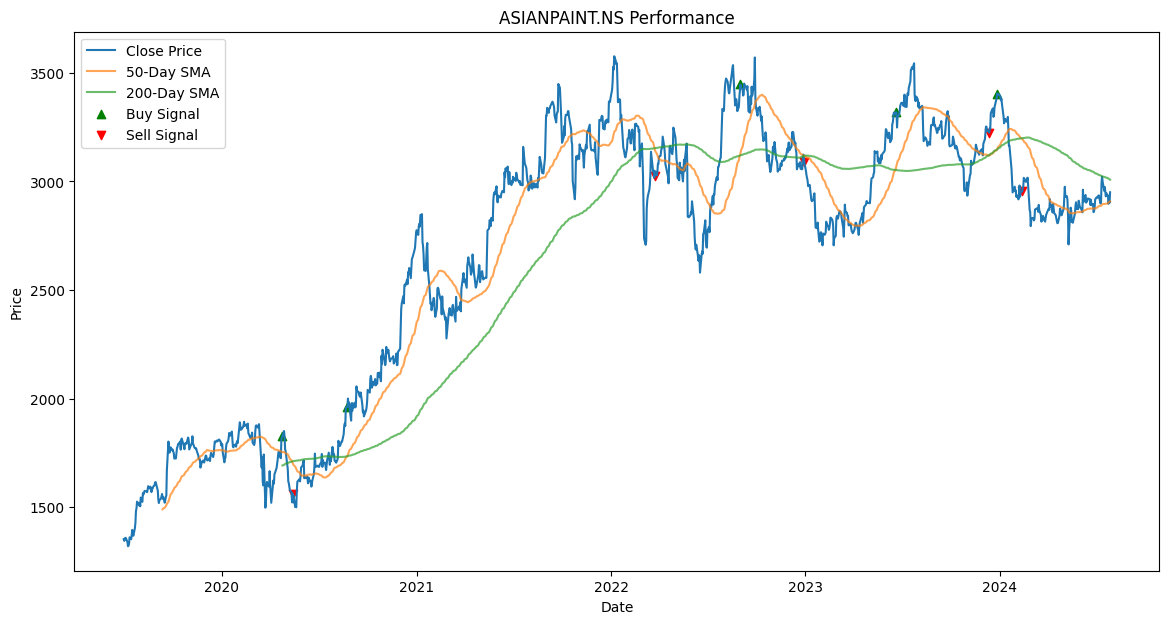

Plotting capital over time for ASIANPAINT.NS


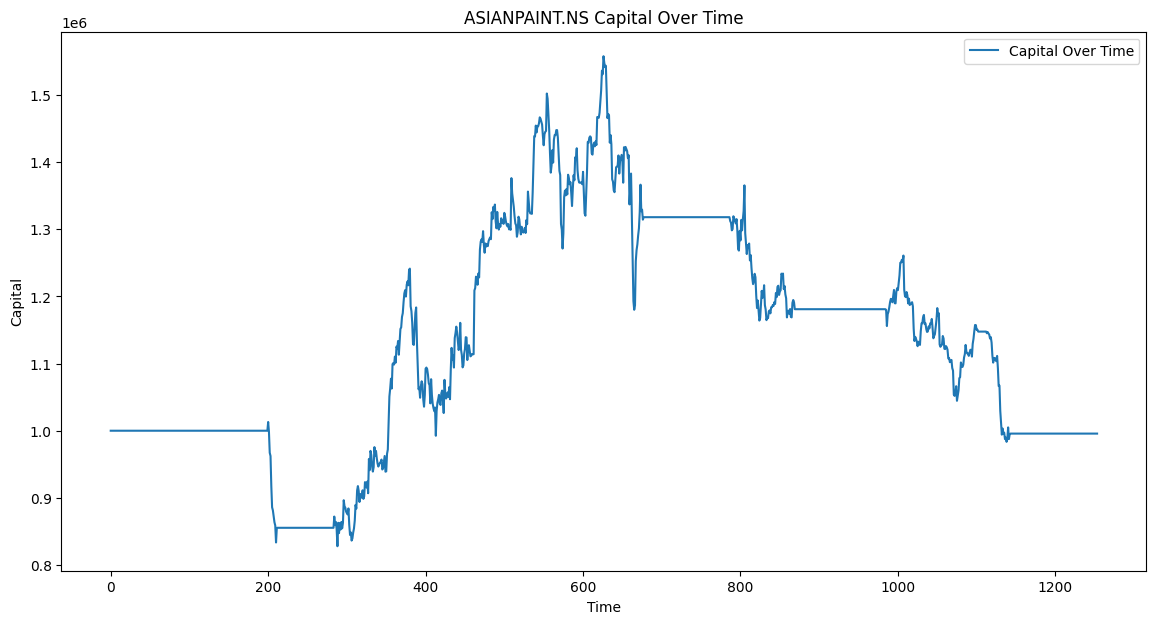

Plotting performance for BAJFINANCE.NS


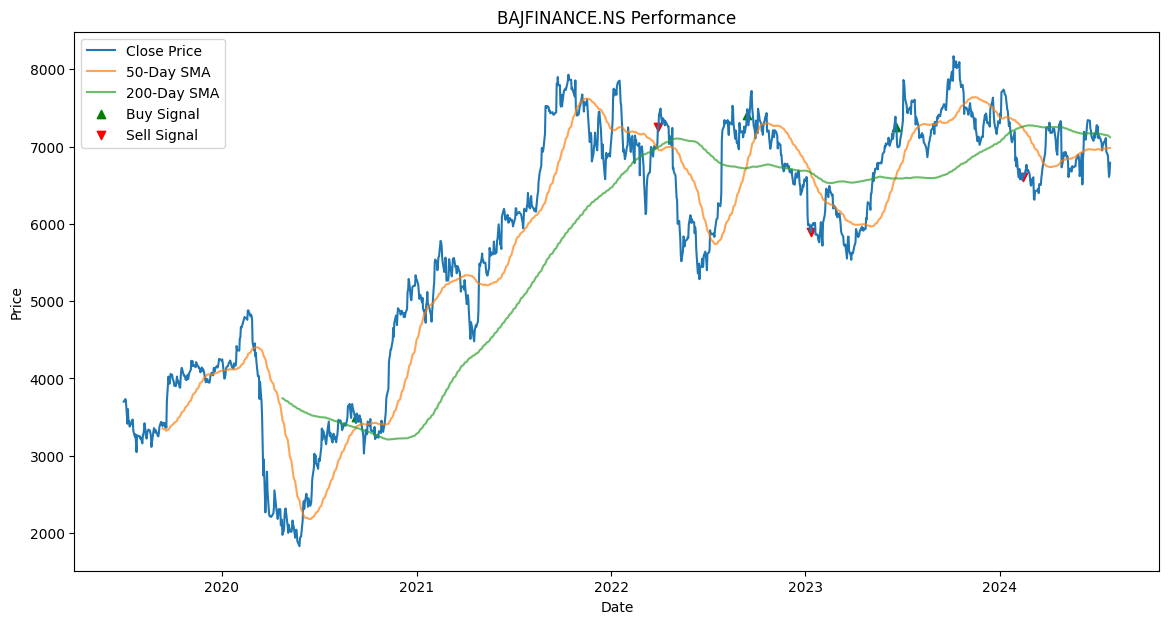

Plotting capital over time for BAJFINANCE.NS


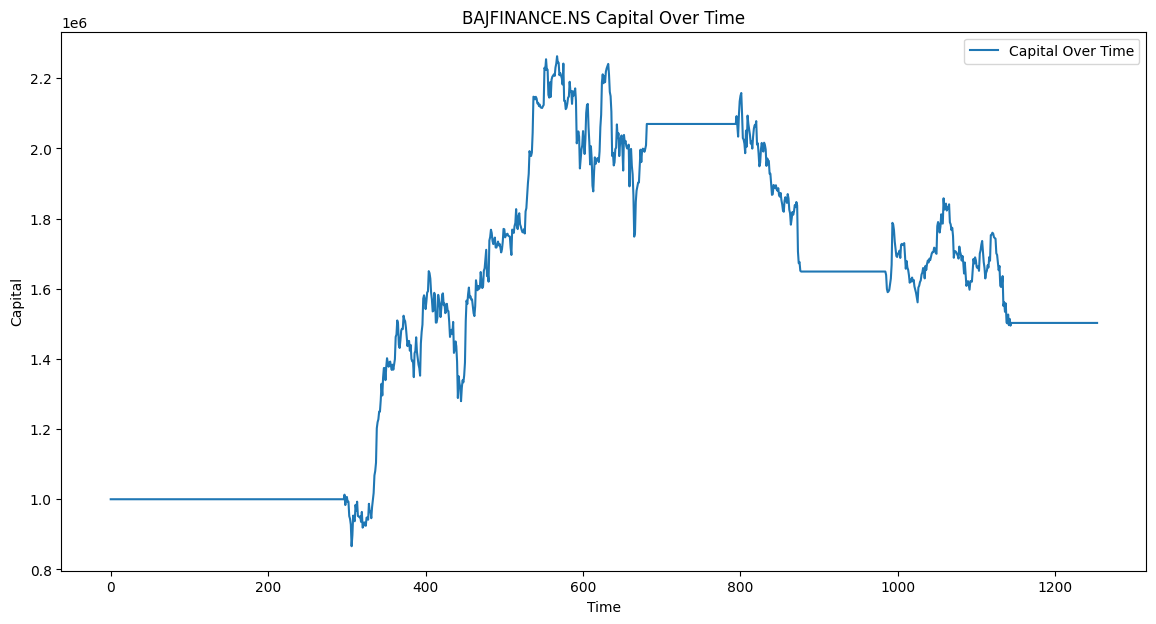

Plotting performance for MARUTI.NS


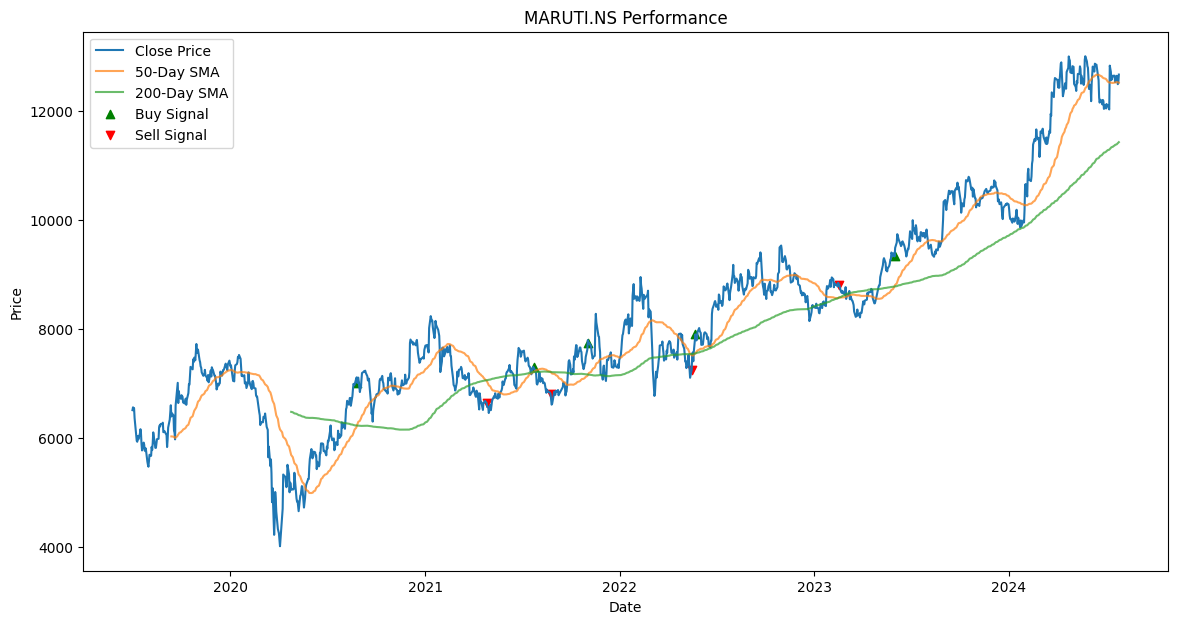

Plotting capital over time for MARUTI.NS


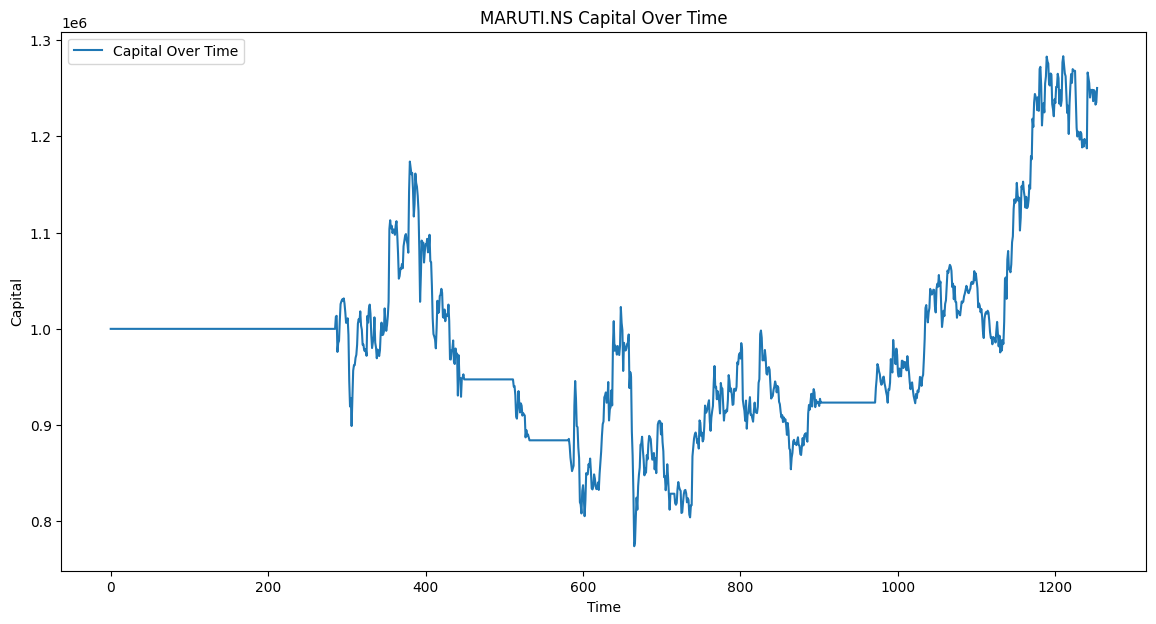

Plotting performance for LT.NS


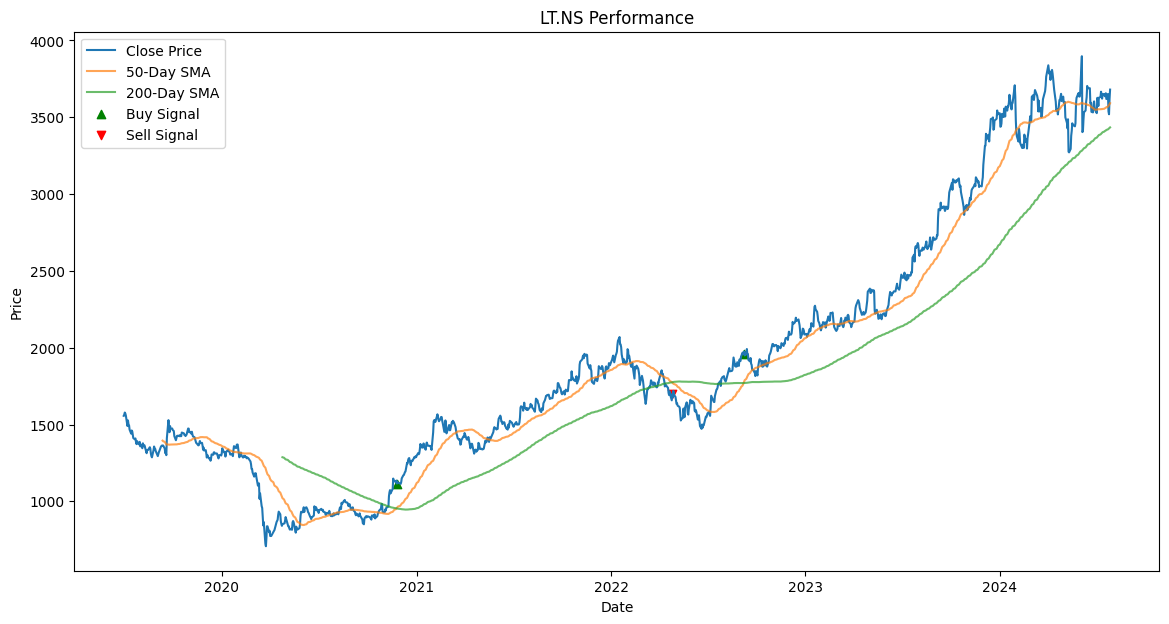

Plotting capital over time for LT.NS


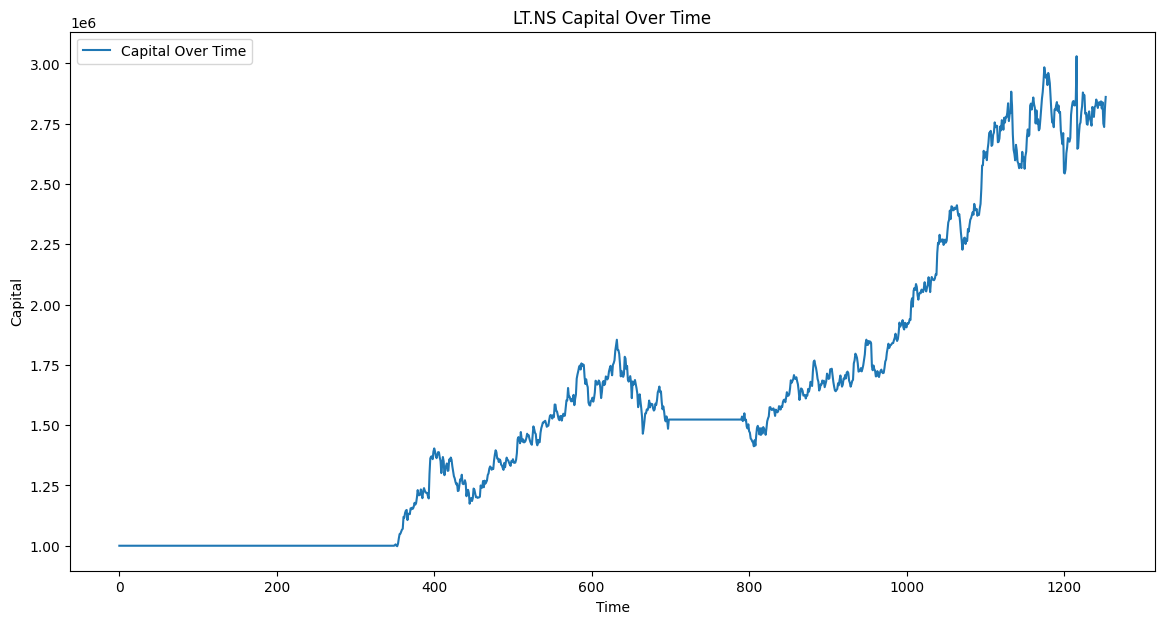

Plotting performance for AXISBANK.NS


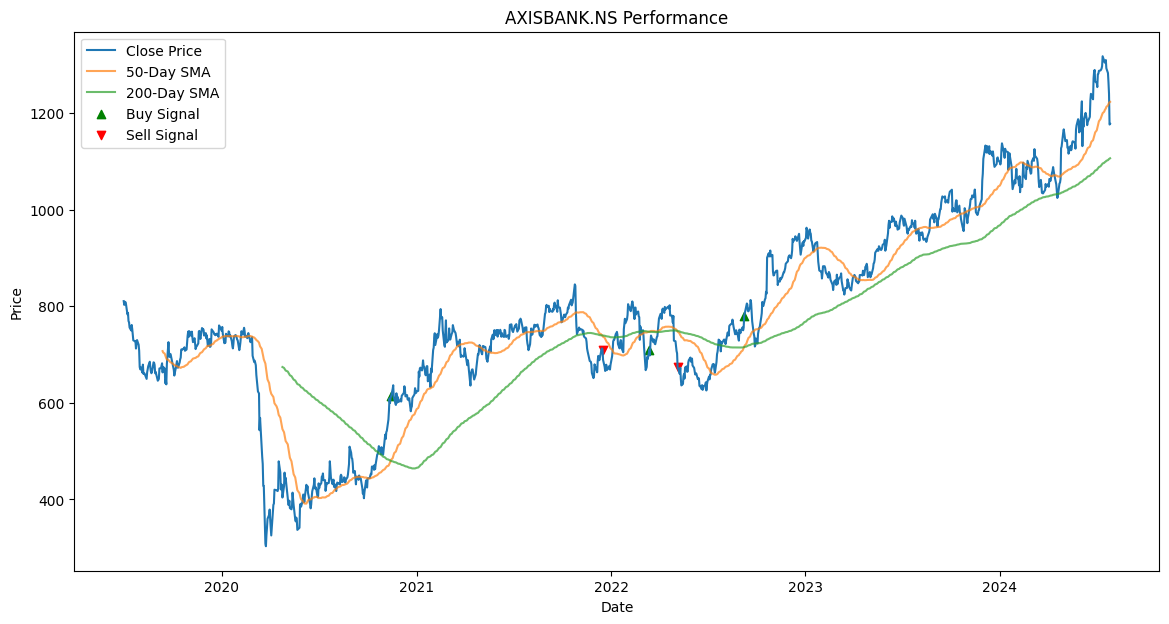

Plotting capital over time for AXISBANK.NS


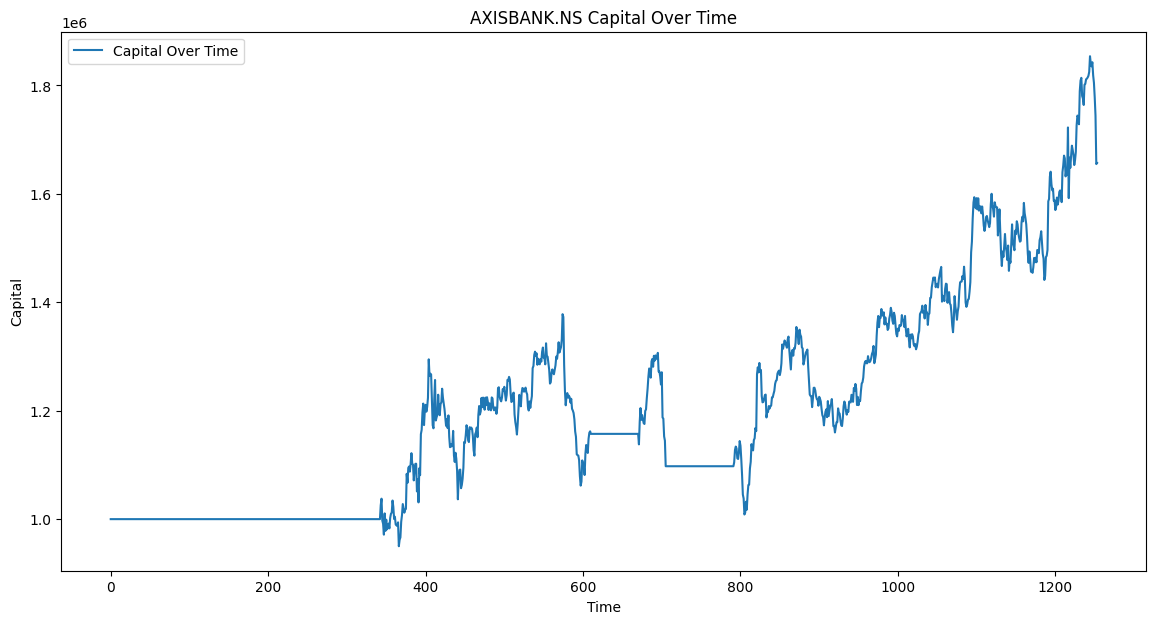

Plotting performance for HCLTECH.NS


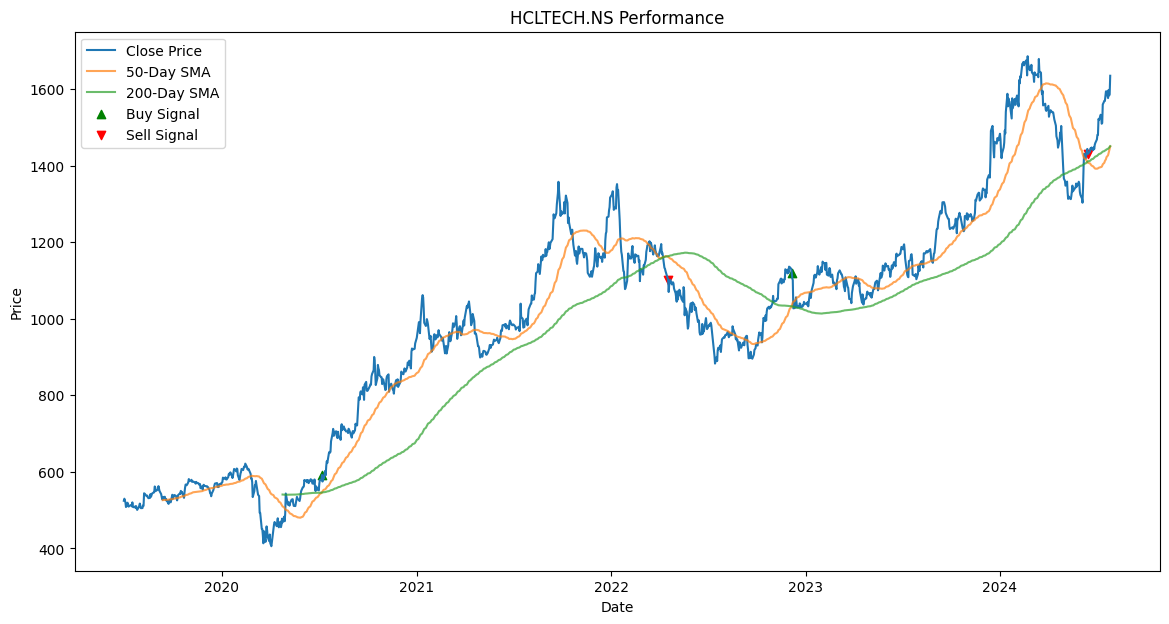

Plotting capital over time for HCLTECH.NS


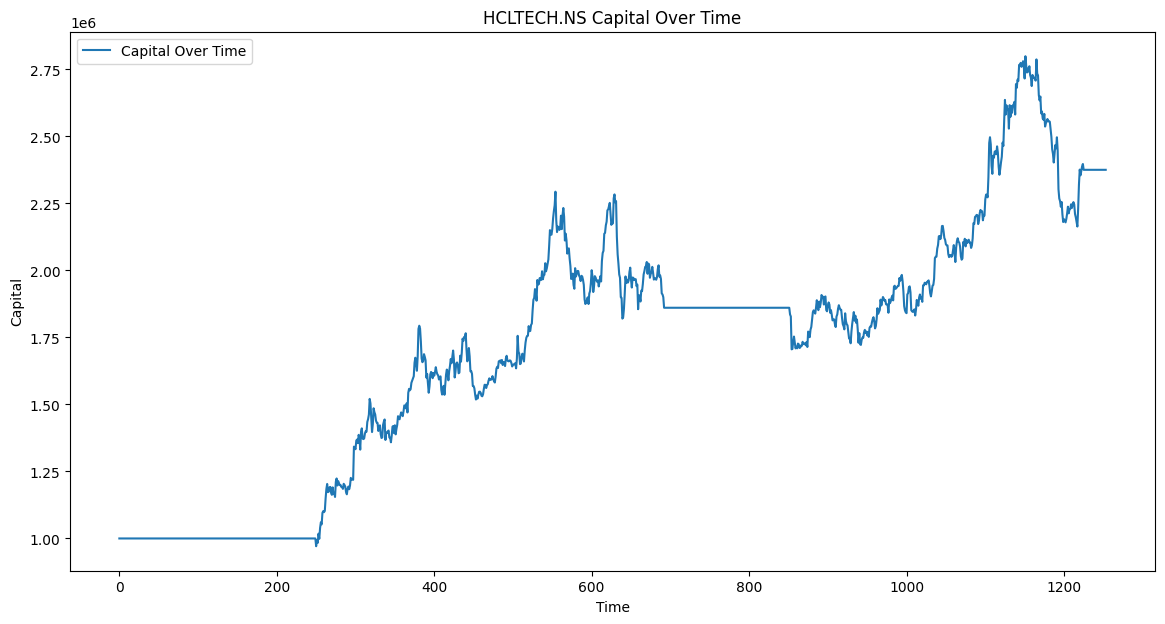

Plotting performance for ULTRACEMCO.NS


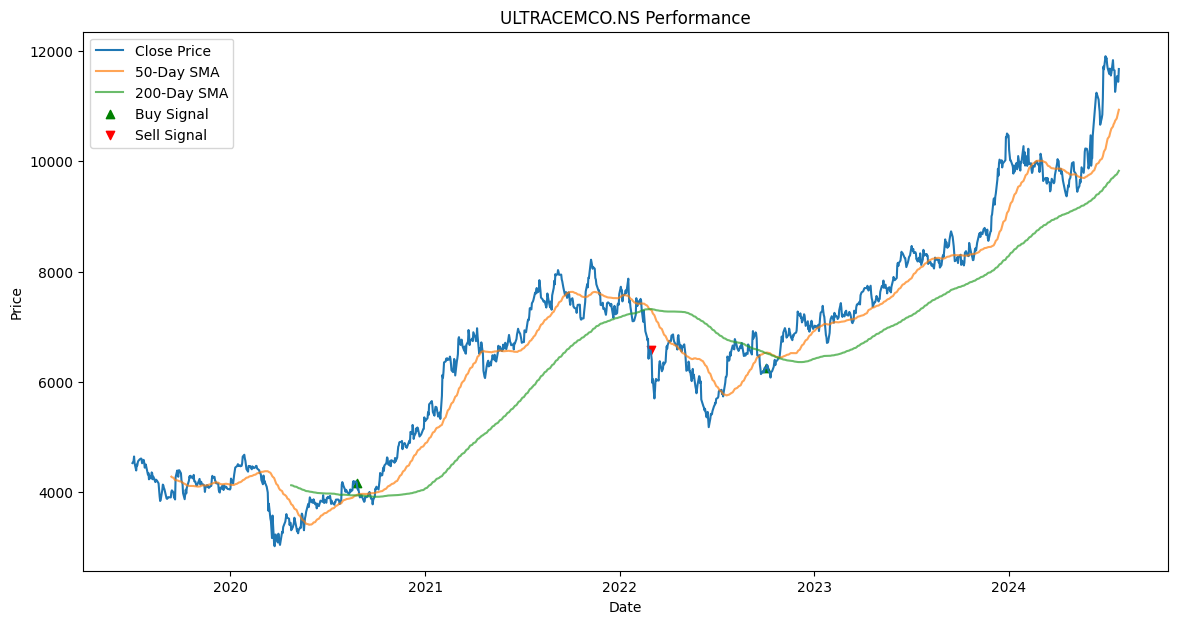

Plotting capital over time for ULTRACEMCO.NS


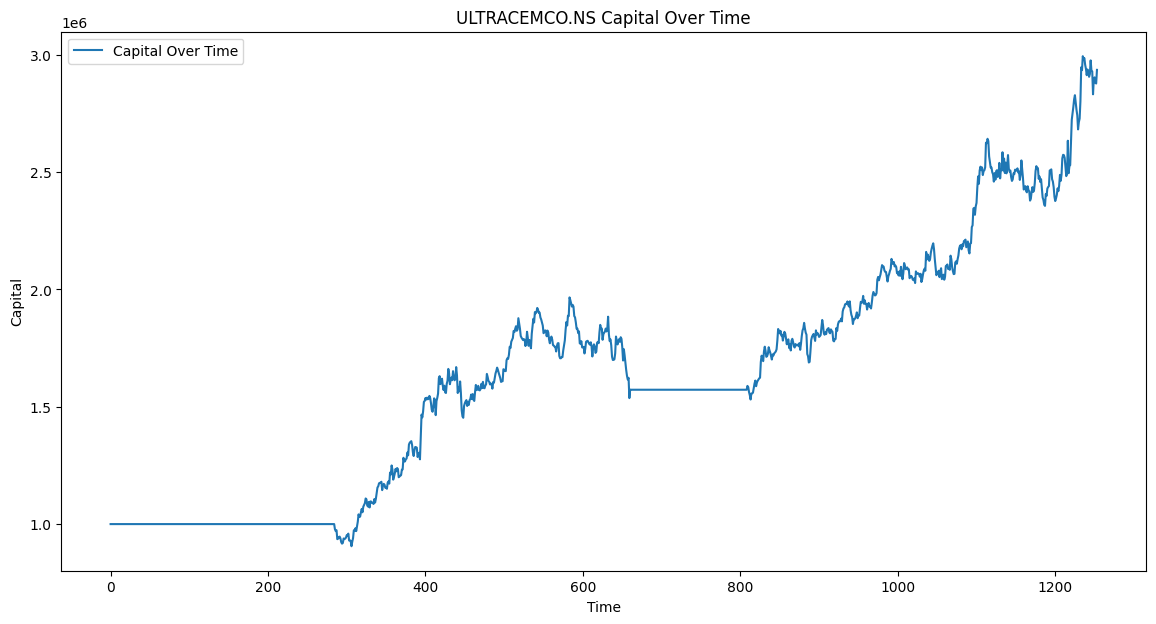

Plotting performance for M&M.NS


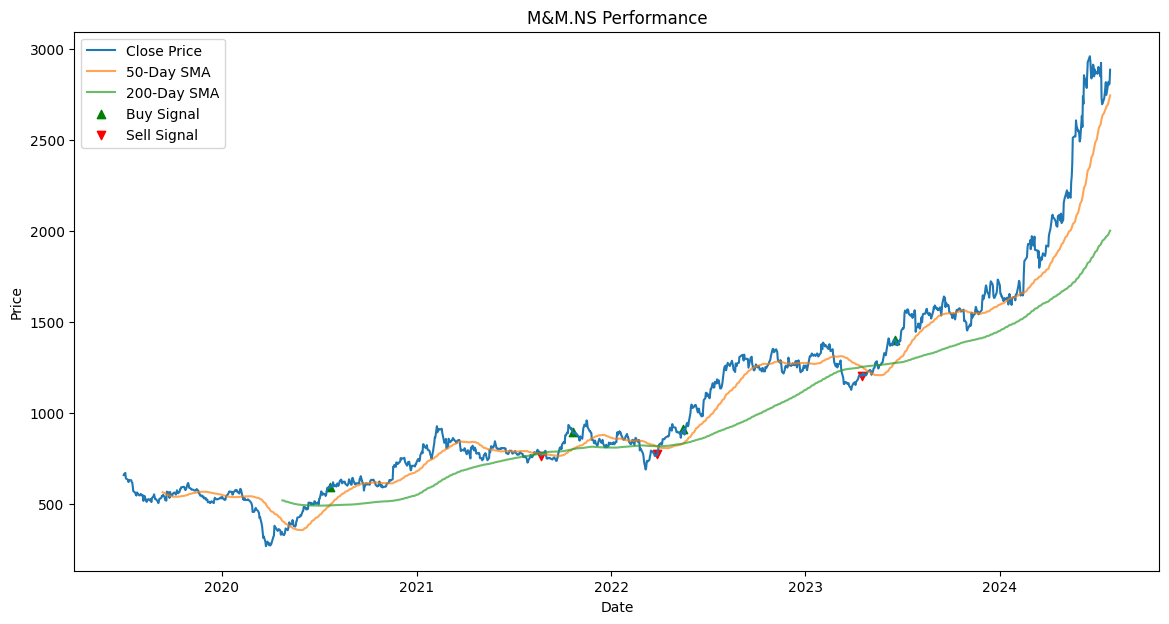

Plotting capital over time for M&M.NS


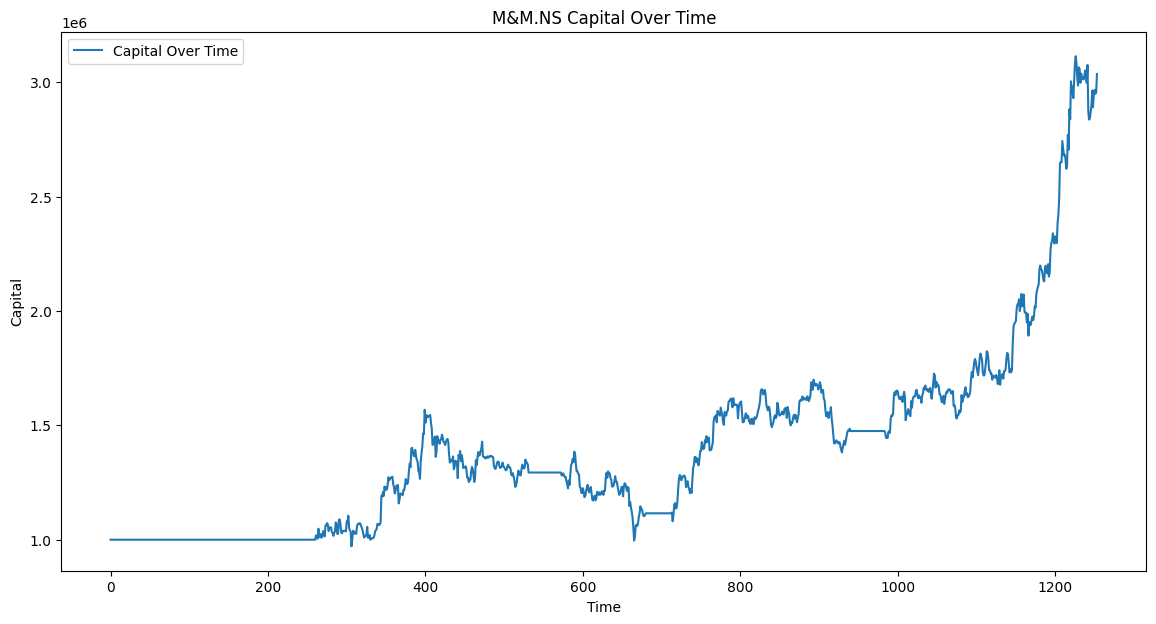

Plotting performance for SUNPHARMA.NS


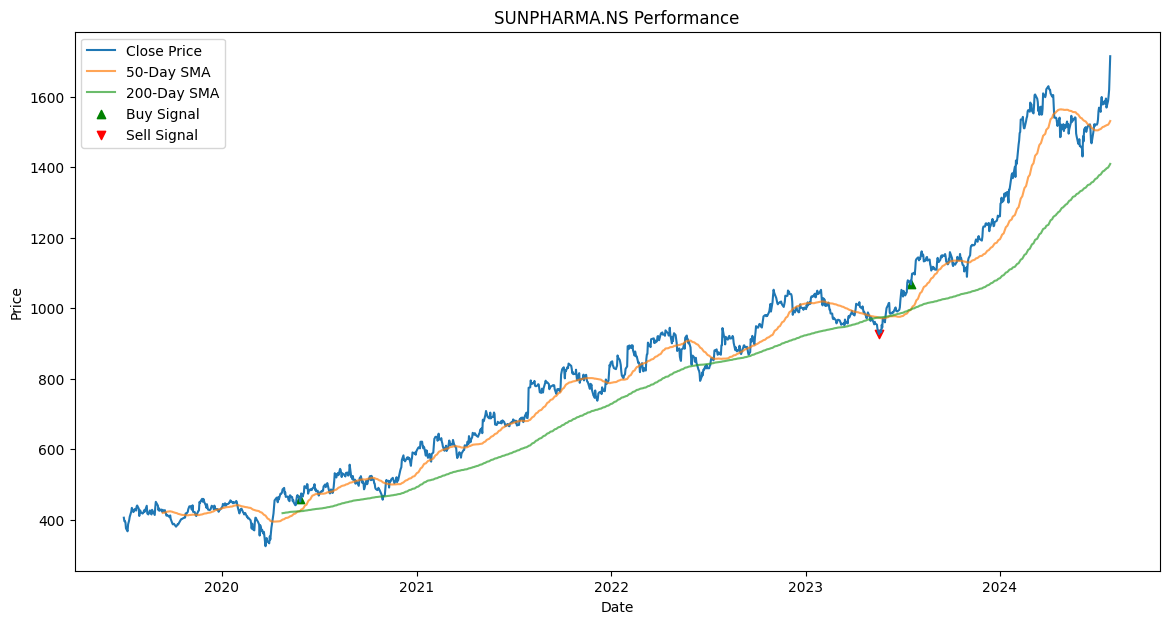

Plotting capital over time for SUNPHARMA.NS


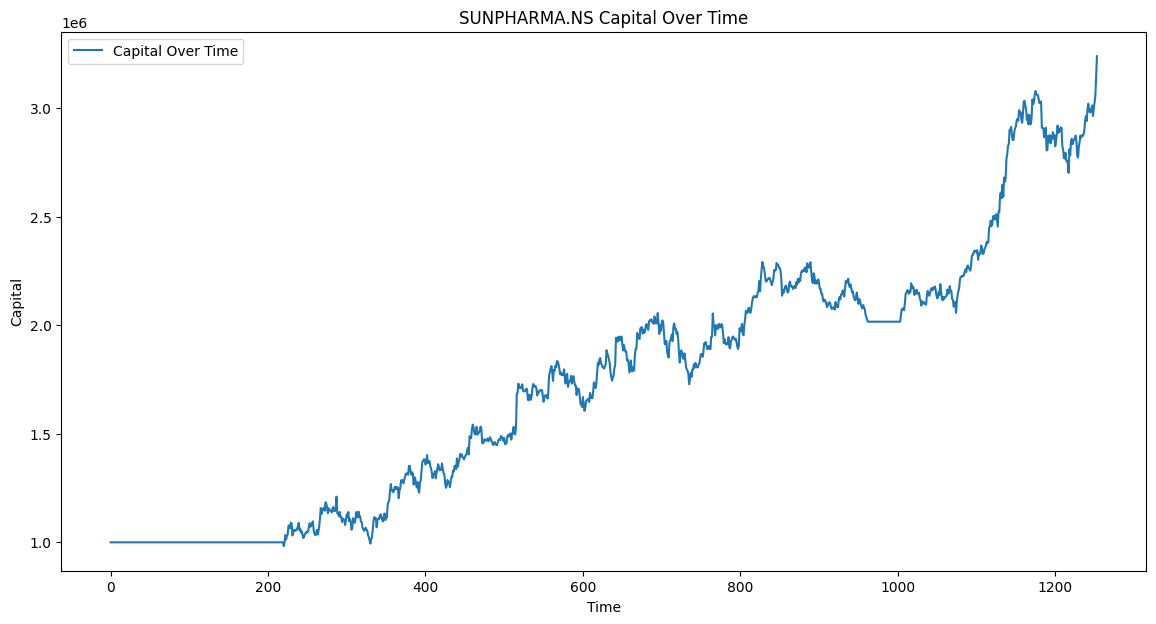

In [4]:
def plot_performance(data, ticker):
    if 'Close' not in data or 'SMA50' not in data or 'SMA200' not in data:
        print(f"Not enough data to plot for {ticker}")
        return

    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['SMA50'], label='50-Day SMA', alpha=0.7)
    plt.plot(data['SMA200'], label='200-Day SMA', alpha=0.7)
    plt.scatter(data.index[data['Position'] == 1], data['Close'][data['Position'] == 1], label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(data.index[data['Position'] == -1], data['Close'][data['Position'] == -1], label='Sell Signal', marker='v', color='red', alpha=1)
    plt.title(f'{ticker} Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_capital(capital_over_time, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(capital_over_time, label='Capital Over Time')
    plt.title(f'{ticker} Capital Over Time')
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.legend()
    plt.show()

for ticker, data in stock_data.items():
    print(f"Plotting performance for {ticker}")
    plot_performance(data, ticker)
    print(f"Plotting capital over time for {ticker}")
    plot_capital(capital_summary[ticker], ticker)


# Section 5: Reporting

In [5]:
# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df.to_csv('backtest_metrics.csv')

# Save positions to CSV
positions_df = pd.concat({k: pd.DataFrame(v) for k, v in positions_summary.items()}, axis=0)
positions_df.to_csv('positions_summary.csv')

print("Metrics and positions saved to CSV.")

# Comprehensive report
with open('comprehensive_report.txt', 'w') as f:
    f.write("Backtesting Comprehensive Report\n")
    f.write("===============================\n\n")
    for ticker, metrics in metrics_summary.items():
        f.write(f"{ticker} Metrics:\n")
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")
print("Comprehensive report generated.")


Metrics and positions saved to CSV.
Comprehensive report generated.
